<a href="https://colab.research.google.com/github/MJMortensonWarwick/AI-DL/blob/main/KF_pipelines_and_TFP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Adapted from the Github link below

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/kubeflow/pipelines/blob/master/components/google-cloud/google_cloud_pipeline_components/experimental/tensorflow_probability/anomaly_detection/tfp_anomaly_detection.ipynb"">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/kubeflow/pipelines/blob/master/components/google-cloud/google_cloud_pipeline_components/experimental/tensorflow_probability/anomaly_detection/tfp_anomaly_detection.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

# Anomaly Detection with TensorFlow Probability STS on Kubeflow Pipelines

## Overview

This notebook demonstrates how to use [TensorFlow Probability](https://www.tensorflow.org/probability) and [Kubeflow Pipelines](https://www.kubeflow.org/docs/components/pipelines/) for anomaly detection in time series data. It uses structural time series (STS), a class of Bayesian statistical models, to decompose a time series into interpretable seasonal and trend components. This algorithm fits an STS model to the time series, generates a forecast of acceptable values for each timestep, and flags any points outside of the forecast as an anomaly. To learn more about STS models, check out this demo on [Structural Time Series Modeling Case Studies](https://www.tensorflow.org/probability/examples/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand).

This demo is used here to demonstrate the use of Kubeflow pipelines (a part of the overall Kubeflow architecture) and Vertex AI solutions.

### Dataset

This demo uses [nyc_taxi.csv](https://github.com/numenta/NAB/blob/d2854d17a3feb9e143b1e9a715c5af67da2c1888/data/realKnownCause/nyc_taxi.csv) which reports the total number of passengers in NYC taxis from July 2014 to January 2015 in 30-minute increments.

### Objective

You will go through the following steps: 
* Define and launch an anomaly detection algorithm on Kubeflow Pipelines.
* Retrieve and visualize results.
* Benchmark predictions using the Numenta Anomaly Benchmark scoring method.

### Costs
This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

### Install additional packages

Install additional package dependencies not installed in your notebook environment.

In [ ]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# Google Cloud Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

In [ ]:
! pip3 install {USER_FLAG} --upgrade kfp
! pip3 install {USER_FLAG} --upgrade google-cloud-pipeline-components
! pip3 install {USER_FLAG} --upgrade tensorflow
! pip3 install {USER_FLAG} --upgrade matplotlib
! pip3 install {USER_FLAG} --upgrade numpy
! pip3 install {USER_FLAG} --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 301 kB 4.3 MB/s 
     |████████████████████████████████| 636 kB 15.3 MB/s 
     |████████████████████████████████| 106 kB 35.9 MB/s 
     |████████████████████████████████| 1.6 MB 20.3 MB/s 
     |████████████████████████████████| 54 kB 1.7 MB/s 
     |████████████████████████████████| 54 kB 1.8 MB/s 
     |████████████████████████████████| 56 kB 1.7 MB/s 
     |████████████████████████████████| 87 kB 5.6 MB/s 
     |████████████████████████████████| 11.1 MB 36.8 MB/s 
     |████████████████████████████████| 76 kB 2.5 MB/s 
     |████████████████████████████████| 54 kB 1.8 MB/s 
  Created wheel for kfp: filename=kfp-1.8.12-py3-none-any.whl size=419048 sha256=cac6c5be19ff4cab427fb69f213b326be48e9680cfb0307cefc7b4f0954b3dfe
  Stored in directory: /root/.cache/pip/wheels/54/0c/4a/3fc55077bc88cc17eacaae34c5fd3f6178c1d16d2ee3b0afdf
  Created wheel for fi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 460 kB 4.2 MB/s 
     |████████████████████████████████| 1.8 MB 48.3 MB/s 
     |████████████████████████████████| 353 kB 60.5 MB/s 
     |████████████████████████████████| 46 kB 3.3 MB/s 
     |████████████████████████████████| 230 kB 46.0 MB/s 
     |████████████████████████████████| 106 kB 43.8 MB/s 
     |████████████████████████████████| 105 kB 50.3 MB/s 
     |████████████████████████████████| 105 kB 48.1 MB/s 
     |████████████████████████████████| 105 kB 48.3 MB/s 
     |████████████████████████████████| 105 kB 40.1 MB/s 
     |████████████████████████████████| 105 kB 35.8 MB/s 
     |████████████████████████████████| 104 kB 49.0 MB/s 
     |████████████████████████████████| 104 kB 49.1 MB/s 
     |████████████████████████████████| 103 kB 39.9 MB/s 
     |████████████████████████████████| 103 kB 43.2 MB/s 
     |████████████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 5.4 kB/s 
     |████████████████████████████████| 1.1 MB 38.2 MB/s 
     |████████████████████████████████| 5.8 MB 33.9 MB/s 
     |████████████████████████████████| 1.6 MB 35.7 MB/s 
     |████████████████████████████████| 438 kB 50.0 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.1
    Uninstalling protobuf-3.20.1:
      Successfully uninstalled protobuf-3.20.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: kera

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 4.4 MB/s 
     |████████████████████████████████| 930 kB 40.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [ ]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required.**

1. Log in to GCP and ensure you know the name of the project your credits are attached to.

1. [Enable the Vertex AI API, Cloud Build API, Cloud Storage API, and Container Registry API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,cloudbuild.googleapis.com,storage.googleapis.com,containerregistry.googleapis.com). **PLEASE CLICK THE LINK TO CONFIRM**

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

In [ ]:
PROJECT_ID = "kfproject-351309"  # @param {type:"string"}

In [ ]:
!gcloud config set project {PROJECT_ID}

Updated property [core/project].


#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

####Authenticate account
Run the below code and give the Notebook authenticated access via the pop-up.

In [ ]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# If on Google Cloud Notebooks, then don't execute this code
if not IS_GOOGLE_CLOUD_NOTEBOOK:
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Create a Cloud Storage bucket

When you submit a training job, Vertex AI saves all resources to the given GCS bucket. We will also use the same bucket to download and host the input data. 

You will need to navigate to GCP and create a storage bucket in **Cloud Storage**. You need to also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Vertex AI services are
available](https://cloud.google.com/vertex-ai/docs/general/locations#available_regions). You may not use ** a Multi-Regional Storage bucket for training with Vertex AI**. (Note this will be the default option - stick with Belgium).

Set the name of your Cloud Storage bucket below.

In [ ]:
BUCKET_NAME = "gs://10piece"  # @param {type:"string"}
REGION = "europe-west1"  # @param {type:"string"}
print(f'Bucket = {BUCKET_NAME}, Region = {REGION}')

Bucket = gs://10piece, Region = europe-west1


### Import libraries and define constants

In [ ]:
PIPELINE_NAME = '{0}-{1}'.format('tfp-anomaly-detection', TIMESTAMP)
PIPELINE_ROOT = '{0}/{1}'.format(BUCKET_NAME, PIPELINE_NAME)

In [ ]:
from typing import Callable, Optional, Mapping, Any

import kfp
from kfp.v2 import compiler
from kfp.v2 import dsl
from kfp.v2.google.client import AIPlatformClient
from kfp.v2.dsl import Input, Output, Dataset

### Define the anomaly detection components

Here you will load components from the [anomaly_detection](https://github.com/kubeflow/pipelines/tree/master/components/google-cloud/google_cloud_pipeline_components/experimental/tensorflow_probability/anomaly_detection) folder in the [Google Cloud Pipeline Components SDK](https://github.com/kubeflow/pipelines/tree/master/components/google-cloud).

You can also save and modify the original Python component file. For example, for [tfp_anomaly_detection.py](https://github.com/kubeflow/pipelines/blob/master/components/google-cloud/google_cloud_pipeline_components/experimental/tensorflow_probability/anomaly_detection/tfp_anomaly_detection.py):

* Call `generate_component_file()` which creates a yaml file.
* Replace the next cell with `anomaly_detection_op = kfp.components.load_component_from_file('component.yaml')`

The components do the following:
* `preprocess`: Regularizes and resamples a time series.
* `tfp_anomaly_detection`: Infers the structure of the time series, fits the model, and identifies anomalies based on the predictive distribution of acceptable values at each timestep.
* `postprocess`: Fills missing values from regularizing and resampling.

In [ ]:
preprocess_op = kfp.components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/master/components/google-cloud/google_cloud_pipeline_components/experimental/tensorflow_probability/anomaly_detection/preprocess.yaml')
anomaly_detection_op = kfp.components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/master/components/google-cloud/google_cloud_pipeline_components/experimental/tensorflow_probability/anomaly_detection/component.yaml')
postprocess_op = kfp.components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/master/components/google-cloud/google_cloud_pipeline_components/experimental/tensorflow_probability/anomaly_detection/postprocess.yaml')

### Define the pipeline

Here you will define the relationship between the components and how data is passed. In this pipeline a Google Cloud Storage csv is imported, the data is preprocessed, anomalies are flagged, and the results are postprocessed so that the output csv is scoreable by the Numenta Anomaly Benchmark.

In [ ]:
@dsl.pipeline(
    pipeline_root=PIPELINE_ROOT, name=PIPELINE_NAME)
def pipeline(input_url: str, memory_limit: str, seed: int) -> None:
  """
      Train model and return detected anomalies.
  """
  input_task = kfp.dsl.importer(
        artifact_uri=input_url,
        artifact_class=Dataset)
  preprocess_task = preprocess_op(input_dataset=input_task.output)
  anomaly_detection_task = anomaly_detection_op(input_dataset=preprocess_task.output, seed=seed).set_memory_limit(memory_limit)
  postprocess_op(input_dataset=input_task.output, predictions_dataset=anomaly_detection_task.output)

In [ ]:
def run_pipeline(pipeline: Callable,
                 parameter_values: Optional[Mapping[str, Any]] = {},
                 enable_caching: bool = False) -> None:
  """Runs a given pipeline function using Kubeflow Pipelines.

  Args:
   pipeline: The function to run.
   parameter_values: Parameters passed to the pipeline function when run.
   enable_caching: Whether to used cached results from previous runs.
  """
  compiler.Compiler().compile(
    pipeline_func=pipeline,
    package_path='{}_pipeline.json'.format(PIPELINE_NAME))

  api_client = AIPlatformClient(
    project_id=PROJECT_ID,
    region=REGION,
  )

  _ = api_client.create_run_from_job_spec(
    job_spec_path='{}_pipeline.json'.format(PIPELINE_NAME),
    pipeline_root=PIPELINE_ROOT,
    parameter_values=parameter_values,
    enable_caching=enable_caching)

### Download the data

Here you will download the Numenta Anomaly Benchmark and upload the dataset to your GCS bucket. We will then find the exact GCS file url associated with the chosen task to pass as the input url into the pipeline.

In [ ]:
import os

NAB_DATA_BLOB = BUCKET_NAME + '/NAB'
if not os.path.exists('content/NAB'):
  !git clone https://github.com/numenta/NAB
!gsutil cp -r NAB/data $NAB_DATA_BLOB

Cloning into 'NAB'...
remote: Enumerating objects: 7029, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 7029 (delta 48), reused 58 (delta 35), pack-reused 6915
Receiving objects: 100% (7029/7029), 86.74 MiB | 14.06 MiB/s, done.
Resolving deltas: 100% (4922/4922), done.
Checking out files: 100% (1186/1186), done.
Copying file://NAB/data/README.md [Content-Type=text/markdown]...
Copying file://NAB/data/realAdExchange/exchange-3_cpc_results.csv [Content-Type=text/csv]...
Copying file://NAB/data/realAdExchange/exchange-2_cpm_results.csv [Content-Type=text/csv]...
Copying file://NAB/data/realAdExchange/exchange-2_cpc_results.csv [Content-Type=text/csv]...
\
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://NA

In [ ]:
# Find the full file path in gcs for the chosen task
import tensorflow as tf

chosen_task_folder = 'realKnownCause'
chosen_task = 'nyc_taxi'
nab_files = tf.io.gfile.glob('{0}/*/*.csv'.format(NAB_DATA_BLOB))
chosen_task_file = [file for file in nab_files if chosen_task in file][0]
print('The pipeline will be run on the task: {0}'.format(chosen_task))

The pipeline will be run on the task: nyc_taxi


### Run the pipeline

Finally, we run the pipeline. Please wait until the run has completed before proceeding to the next steps.

You will see a link after "See the Pipeline job". Click on this to track progress. You should see something like this:
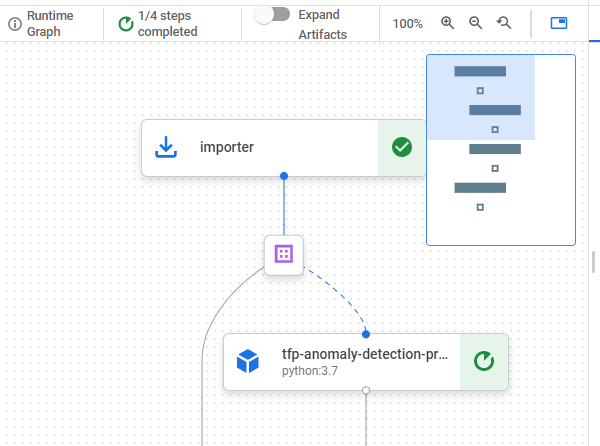

In [ ]:
parameter_values = {
  'input_url': chosen_task_file,
  'memory_limit': '50G',
  'seed': 0,
}
run_pipeline(pipeline, parameter_values=parameter_values)

/usr/local/lib/python3.7/dist-packages/kfp/v2/compiler/compiler.py:1281: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,
/usr/local/lib/python3.7/dist-packages/kfp/dsl/__init__.py:32: FutureWarning: `kfp.dsl.importer` is a deprecated alias and will be removed in KFP v2.0. Please import from `kfp.v2.dsl` instead.
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/kfp/v2/google/client/client.py:173: FutureWarning: AIPlatformClient will be deprecated in v2.0.0. Please use PipelineJob https://googleapis.dev/python/aiplatform/latest/_modules/google/cloud/aiplatform/pipeline_jobs.html in Vertex SDK. Install the SDK using "pip install google-cloud-aiplatform"
  category=FutureWarning,


HttpError: ignored

Once the training job has finished you should see each stage has a green tick on the linked web page. You can navigate to the bottom box (`postprocess`) to get the link for the output


### Download the results locally

Copy the GCS file path from the final `postprocess` step of the pipeline below. Here we will save this output locally for visualization and scoring.

In [ ]:
import pandas as pd
import numpy as np
import json

In [ ]:
gcs_file = '[your-pipeline-output]' # @param {type:'string'}
output_file = '/content/{0}-{1}.csv'.format(chosen_task, TIMESTAMP)
!gsutil cp $gcs_file $output_file

In [ ]:
# Collect targets specifically for the chosen task
targets = json.load(open('/content/NAB/labels/combined_labels.json'))
chosen_task_targets = [targets[key] for key in targets if chosen_task in key][0]

### Visualize the results

Here we will plot the forecast distribution outputted by the pipeline, the points flagged as anomalies (red), and the ground truth targets (green). The graph is plotted with daily granularity due to the resampling done during preprocessing.

Note how the algorithm correctly identifies December 25th as an anomaly.

In [ ]:
#@title Plotting setup
from matplotlib import pylab as plt
from matplotlib.lines import Line2D

def plot_predictions(predictions: pd.DataFrame, annotation_fn: Callable = lambda timestamp: timestamp) -> None:
  """
    Plots the time series, forecast, detected anomalies, and residuals.

    Args:
      predictions: The output of the anomaly detection algorithm.
  """
  # Drop NaN values during plotting
  predictions = predictions.dropna(how='any')
  predictions = predictions.reset_index()

  timestamp = pd.to_datetime(predictions['timestamp'], format='%Y-%m-%d')
  # Plot the value from predictions which may be
  # an aggregation of the original value
  value = np.array(predictions['value_predictions'])
  lower_limit = np.array(predictions['lower_limit'])
  upper_limit = np.array(predictions['upper_limit'])
  mean = np.array(predictions['mean'])
  anomalies = np.array(predictions['label']).nonzero()[0]
  targets = []
  if 'target' in predictions:
    targets = np.array(predictions['target']).nonzero()[0]

  fig = plt.figure(figsize=(10, 5), constrained_layout=True)
  spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[2., 1.])
  series_ax = fig.add_subplot(spec[0, 0])
  residuals_ax = fig.add_subplot(spec[1, 0], sharex=series_ax)

  # Plot anomalies on series_ax
  series_ax.plot(
      timestamp,
      value,
      color='black',
      alpha=0.6)
  series_ax.fill_between(
      timestamp,
      lower_limit,
      upper_limit,
      color='tab:blue',
      alpha=0.3)

  for anomaly_idx in anomalies:
    x = timestamp[anomaly_idx]
    y = value[anomaly_idx]
    series_ax.scatter(x, y, s=100, alpha=0.4, c='red')
  
  for target_idx in targets:
    x = timestamp[target_idx]
    y = value[target_idx]
    series_ax.scatter(x, y, s=100, alpha=0.4, c='green')
    series_ax.annotate(annotation_fn(x), (x, y))

  # Plot residuals on residuals_ax
  time_delta = timestamp[1] - timestamp[0]
  residuals_ax.bar(
      timestamp,
      height=upper_limit - lower_limit,
      bottom=lower_limit - mean,
      width=time_delta,
      align='center',
      color='tab:blue',
      alpha=0.3)
  residuals_ax.bar(
      timestamp,
      width=time_delta,
      height=value - mean,
      align='center',
      color='black',
      alpha=0.6)

  # Set up grid styling
  series_ax.set_ylabel('Original series')
  residuals_ax.set_ylabel('Residuals')
  series_ax.grid(True, color='whitesmoke')
  residuals_ax.grid(True, color='whitesmoke')
  series_ax.set_axisbelow(True)
  residuals_ax.set_axisbelow(True)

  # Add title and legend
  series_ax.set_title('TFP STS model forecast, anomalies, and residuals for {0}'.format(chosen_task))
  create_legend_label = lambda label, color: Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
  legend_elements = [create_legend_label(label, color) for label, color in [('predicted anomaly', 'red'), ('target', 'green')]]
  series_ax.legend(handles=legend_elements, loc='lower right')

In [ ]:
# Round target timestamps to day for plotting
round_to_day = lambda timestamp: timestamp.split()[0]
rounded_targets = [round_to_day(timestamp) for timestamp in chosen_task_targets]
rounded_targets = set(rounded_targets)
predictions = pd.read_csv(output_file)
predictions['target'] = predictions.apply(lambda df: round_to_day(df['timestamp']) in rounded_targets, axis=1)

In [ ]:
# Change the start and end to view different slices of the prediction
start, end = 8000, 9000
round_annotation = lambda timestamp: timestamp.date()
plot_predictions(predictions.iloc[start:end], round_annotation)